# Get and explore dataset

In [193]:
# Relevant libraries and packages are imported for manipulation

import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re
import statistics
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.utils import to_categorical

In [194]:
# Make results reproducible -random seed is set

from numpy.random import seed
seed(42)

In [195]:
# Datasets are created from the specified files

negative_file = "negative.txt"
positive_file = "positive.txt"

In [196]:
# Helper functions are defined to pre process the data

def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label

def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label

def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in y]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1

def to_class(y):
    return np.argmax(y,axis=1) 

In [197]:
# The first ten entries of each dataset are printed out

positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [198]:
# Combines the positive and negative reviews into a single list and create labels

data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)

labels  = to_categorical(to_numeric_label(word_labels))
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Mean review length:  24.676519799219186
Standard deviation of review lengths:  11.28405192884278
Number of unique words:  2559


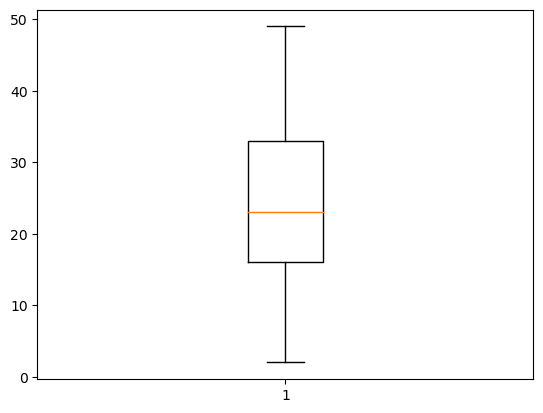

In [199]:

# - Calculate and report the mean review size, its standard deviation and create a boxplot.
# - Calculate the number of unique words in the dataset
# - Perform any other dataset investigation that you feel would be valuable

from collections import Counter

# The mean review size, its standard deviation are calculated and a boxplot is plotted

review_lengths = [len(review) for review in data]
mean_review_length = np.mean(review_lengths)
std_review_length = np.std(review_lengths)
print('Mean review length: ', mean_review_length)
print('Standard deviation of review lengths: ', std_review_length)

plt.boxplot(review_lengths)

# The number of unique words in the dataset is calculated and displayed 

unique_words = set(' '.join(data).split())
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)




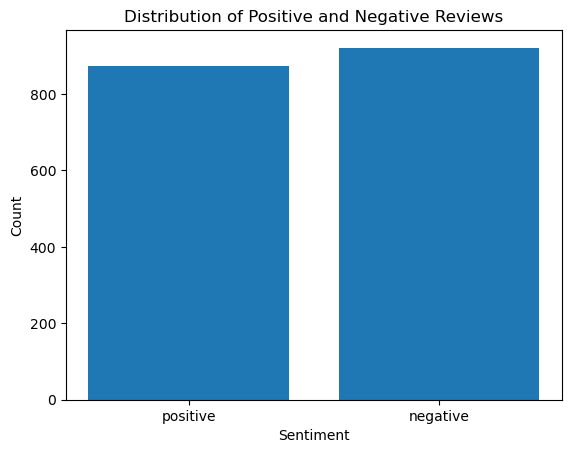

In [200]:
# The number of positibe vs negative sentiments are plotted

label_counts = Counter(word_labels)
plt.bar(label_counts.keys(), label_counts.values())
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [201]:
# The vocabulary is tokenized

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

#  Compare a sample of the data before and after tokenization

print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


# Pre-processing

In [202]:
# Pre-processing
# The data is pre processed so that each review is the same length

from keras_preprocessing.sequence import pad_sequences

max_length = 50 # maximum length of each review

padded_data = pad_sequences(tokenized_data, maxlen=max_length, padding='post', truncating='post')


In [203]:
# The data is split for further modelling

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tokenized_data, labels, test_size=0.2, shuffle=True)

train_data = pad_sequences(X_train, maxlen=max_length, padding='post')
test_data = pad_sequences(X_test, maxlen=max_length, padding='post')

# import numpy as np

# print('X_train shape:', np.array(X_train).shape)
# print('X_test shape:', np.array(X_test).shape)
# print('y_train shape:', np.array(y_train).shape)
# print('y_test shape:', np.array(y_test).shape)


In [204]:
# A function is defined to calculate the characteristics of the model

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def assess_model(model, X_test, y_test):      
    y_pred = model.predict(X_test)
    y_pred_classes = to_class(y_pred)
    y_test_classes = to_class(y_test)
    
    precision = precision_score(y_test_classes, y_pred_classes)
    recall = recall_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes)
    confusion = confusion_matrix(y_test_classes, y_pred_classes)
    
    print("Confusion Matrix:\n", confusion)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


# Build and tune model

Define network architecture

In [205]:
# The input and output dimensions are specified and a model is created

input_dim = vocab_size
output_dim = 128
input_length = max_length

model = Sequential()

model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


Train model

In [206]:

# The data is split inot training and test sets

X_train_val, X_test, y_train_val, y_test = train_test_split(padded_data, labels, test_size=0.2, shuffle=True)

# The data is split into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=True)

# The data is converted to arrays

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# The model is compiled and fitted

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# The model is evaluated

assess_model(model, X_test, y_test)


Epoch 1/10
36/36 [==============================] - 15s 332ms/step - loss: 0.6951 - accuracy: 0.4987 - val_loss: 0.6933 - val_accuracy: 0.4599
Epoch 2/10
36/36 [==============================] - 11s 302ms/step - loss: 0.6934 - accuracy: 0.5170 - val_loss: 0.6917 - val_accuracy: 0.5401
Epoch 3/10
36/36 [==============================] - 10s 289ms/step - loss: 0.6931 - accuracy: 0.5205 - val_loss: 0.6907 - val_accuracy: 0.5401
Epoch 4/10
36/36 [==============================] - 10s 286ms/step - loss: 0.6931 - accuracy: 0.5196 - val_loss: 0.6917 - val_accuracy: 0.5401
Epoch 5/10
36/36 [==============================] - 10s 285ms/step - loss: 0.6937 - accuracy: 0.5187 - val_loss: 0.6918 - val_accuracy: 0.5401
Epoch 6/10
36/36 [==============================] - 10s 286ms/step - loss: 0.6930 - accuracy: 0.5144 - val_loss: 0.6909 - val_accuracy: 0.5401
Epoch 7/10
36/36 [==============================] - 10s 285ms/step - loss: 0.6932 - accuracy: 0.5205 - val_loss: 0.6909 - val_accuracy: 0.5401

Examine performance of model

The precision is, the accuracy is 0.47 , and the F1 score is 0.64
so the model does not perform very well.

Plot graphs for accuracy and loss

Epoch 1/10
36/36 [==============================] - 10s 280ms/step - loss: 0.6928 - accuracy: 0.5196 - val_loss: 0.6907 - val_accuracy: 0.5401
Epoch 2/10
36/36 [==============================] - 10s 284ms/step - loss: 0.6928 - accuracy: 0.5196 - val_loss: 0.6909 - val_accuracy: 0.5401
Epoch 3/10
36/36 [==============================] - 10s 284ms/step - loss: 0.6924 - accuracy: 0.5196 - val_loss: 0.6908 - val_accuracy: 0.5401
Epoch 4/10
36/36 [==============================] - 10s 288ms/step - loss: 0.6930 - accuracy: 0.5196 - val_loss: 0.6910 - val_accuracy: 0.5401
Epoch 5/10
36/36 [==============================] - 10s 277ms/step - loss: 0.6926 - accuracy: 0.5196 - val_loss: 0.6906 - val_accuracy: 0.5401
Epoch 6/10
36/36 [==============================] - 10s 280ms/step - loss: 0.6926 - accuracy: 0.5196 - val_loss: 0.6905 - val_accuracy: 0.5401
Epoch 7/10
36/36 [==============================] - 10s 276ms/step - loss: 0.6936 - accuracy: 0.4996 - val_loss: 0.6911 - val_accuracy: 0.5401

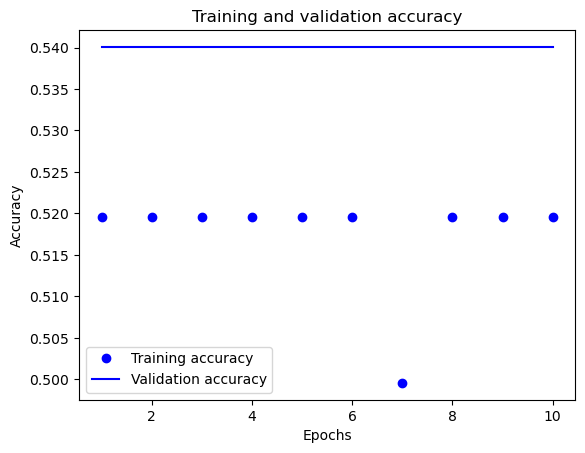

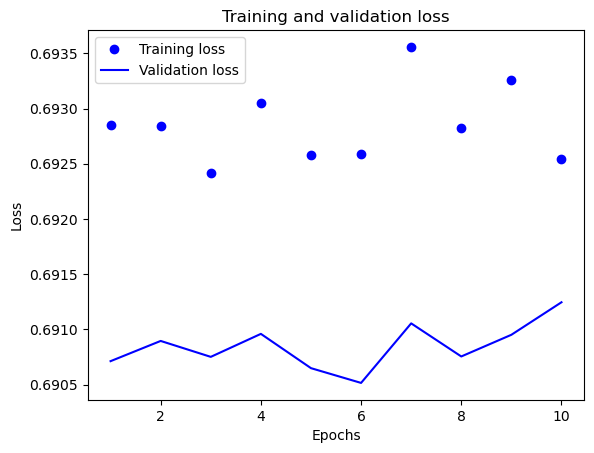

In [207]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Training and validation accuracy and loss over epochs are recieved

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plot

plt.show()

# Plot training and validation loss

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plot

plt.show()


# Make a prediction

In [221]:
# A small set of data is used to test the data

prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = pad_sequences(tokenized, padding='post', maxlen=max_length)

# Predict with the model

predictions = model.predict(padded)


# The predicted probabilities are converted to class labels 

predicted_classes = np.argmax(predictions.reshape(predictions.shape[0], -1), axis=1).reshape(-1,1)


# Map the class labels to text labels

predicted_labels = to_word_label(predicted_classes)

predicted_labels
np.argmax(predictions, axis=1)

# Print the results

for i in range(len(prediction_data)):
     print(prediction_data[i], "is", predicted_labels[i])


1/1 [==============================] - 0s 35ms/step
this book is fabulous is positive
i hated this book is positive
the best is positive
no good is positive
okay is positive
